In [1]:
df_sim = spark.read.parquet("gs://msca-bdp-students-bucket/shared_data/suyashlakhani/tweets6")

**4.3 Visualize message duplication for each group of Twitterers (government entities / health organizations / news outlets / social media influencers / other)**


In [2]:
import os
import shutil
from itertools import islice
import requests

import pandas as pd
import matplotlib.pyplot as plt

import findspark
findspark.init()

from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql import functions as F
from pyspark.sql.types import *
import re
from pyspark.ml.feature import MinHashLSH
from pyspark.ml.feature import CountVectorizer,  IDF, CountVectorizerModel, Tokenizer, RegexTokenizer, StopWordsRemover
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql import Row
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

# Create spark_session
spark = SparkSession.builder.getOrCreate()
conf = spark.sparkContext._conf.setAll([('spark.executor.memory', '32g'), ('spark.app.name', 'Spark Updated Conf'), 
                                        ('spark.executor.cores', '32'), ('spark.cores.max', '32'), ('spark.driver.memory','32g')])
spark.sparkContext.getConf().getAll()

from IPython.display import clear_output
clear_output(wait = False)

spark.version

import time
start_time = time.time()

In [3]:
def get_tokens(df):
    return df\
        .map( lambda document: re.sub(r'[^a-zA-Z0-9 ]', '', document))\
        .map( lambda document: document.strip().lower())\
        .map( lambda document: re.split(" ", document))\
        .map( lambda word: [x for x in word if len(x) >= 2] )\
        .map( lambda word: [x for x in word if x not in StopWords])\
        .zipWithIndex()

def to_DF(rdd_, col):    
    row = Row(col)
    return rdd_.map(row).zipWithIndex().toDF([col, 'id'])

def token_cleaning(tokens):
    df_tokens = spark.createDataFrame(tokens, ["list_of_words",'id'])
    df_tokens = df_tokens.where(col('list_of_words').getItem(0).isNotNull())
    return df_tokens

mh = MinHashLSH(inputCol = "features", outputCol = "hashes", numHashTables = 5)
def get_df_hashed(df_vectorize):
    model = mh.fit(df_vectorize)
    df_hashed = mh.fit(df_vectorize).transform(df_vectorize)
    return model, df_hashed

def getJaccardBarChart(df, jaccard_distance,model):

    df_dups_text = model.approxSimilarityJoin(
                        df, df, jaccard_distance
                    ).filter("datasetA.id < datasetB.id").select(
                        col("distCol"),
                        col("datasetA.id").alias("id_A"),
                        col("datasetB.id").alias("id_B"),
                        col("datasetA.text").alias('text_A'),
                        col("datasetB.text").alias('text_B')
                    )

    df_dups_text.cache()
    #df_dups_text.limit(5).toPandas()
    
    records = df.count()
    dups = df_dups_text.select('id_A').distinct().count()
    uniques = records - dups
    
    return df_dups_text, records, dups

In [4]:
#Using Jaccard similarity for all organisations (Entities)
StopWords = stopwords.words("english")
def similarity(i, fraction_sample, complete = None):
    if(complete == None):
        df_analysis = df_sim.filter("Organization == '" + i + "'")
        df_analysis = df_analysis.sample(fraction = fraction_sample, seed = 42)
    else:
        df_analysis = df_tweets_main
        df_analysis = df_analysis.sample(fraction = fraction_sample, seed = 42)
    
    df_analysis = df_analysis.cache()
    tweet = df_analysis.rdd.map(lambda x : x['text'])

    global StopWords
    tweet_tokens = get_tokens(tweet)

    df_tweets = to_DF(tweet, 'text')
    df_tweets_tokens = token_cleaning(tweet_tokens)

    vectorize = CountVectorizer(inputCol="list_of_words", outputCol="features", minDF=1.0)
    df_tweets_tokens_vectorized = vectorize.fit(df_tweets_tokens).transform(df_tweets_tokens)

    model, df_hashed= get_df_hashed(df_tweets_tokens_vectorized)

    df_hashed_text_joined = df_tweets.join(df_hashed, "id", how = 'left')

    df_hashed_text_joined = df_hashed_text_joined.\
                                where(size(df_hashed_text_joined.list_of_words) >= 5)

    text_dups_list = []
    df_dups_text_20, records, dups = getJaccardBarChart(df_hashed_text_joined, 0.2,model)
    text_dups_list.append([records, dups, records - dups, 0.2])

    df_dups_text_40, records, dups = getJaccardBarChart(df_hashed_text_joined, 0.4,model)
    text_dups_list.append([records, dups, records - dups, 0.4])

    df_dups_text_50, records, dups = getJaccardBarChart(df_hashed_text_joined, 0.5,model)
    text_dups_list.append([records, dups, records - dups, 0.5])

    df_dups_text_60, records, dups = getJaccardBarChart(df_hashed_text_joined, 0.6,model)
    text_dups_list.append([records, dups, records - dups, 0.6])

    df_dups_text_70, records, dups = getJaccardBarChart(df_hashed_text_joined, 0.7,model)
    text_dups_list.append([records, dups, records - dups, 0.7])

    df_ = pd.DataFrame(text_dups_list, columns = ['counts', 'dups', 'unique', 'threshold'])
    df_.plot(x = 'threshold', y = ['unique','dups'], kind = 'bar', title = i,color=["blue","green"])
    plt.show()
    return text_dups_list

In [5]:
Organization_data = []

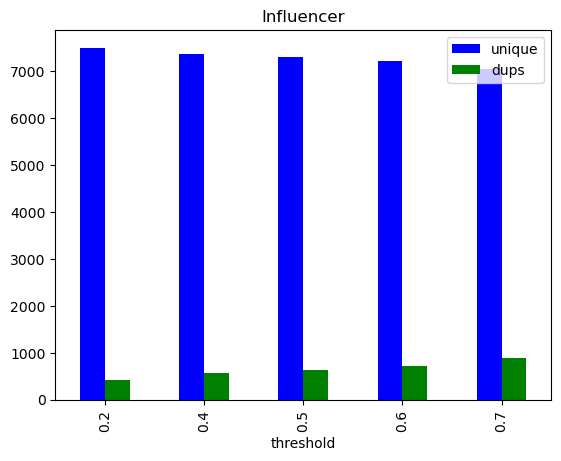

In [6]:
Organization_data.append(similarity("Influencer", 1.0))

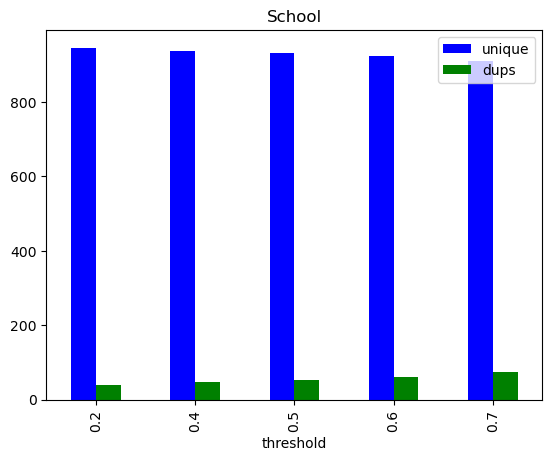

In [7]:
Organization_data.append(similarity("School", 1.0))

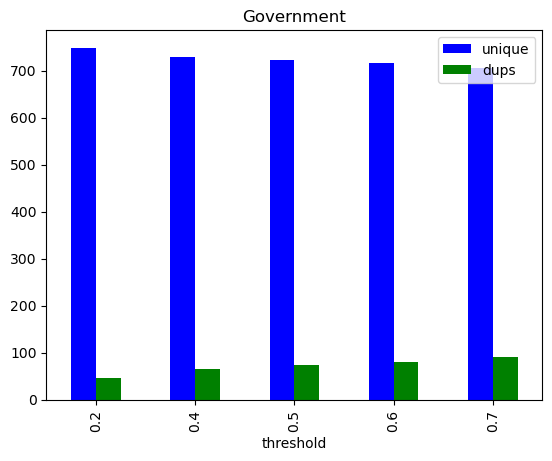

In [8]:
Organization_data.append(similarity("Government", 1.0))

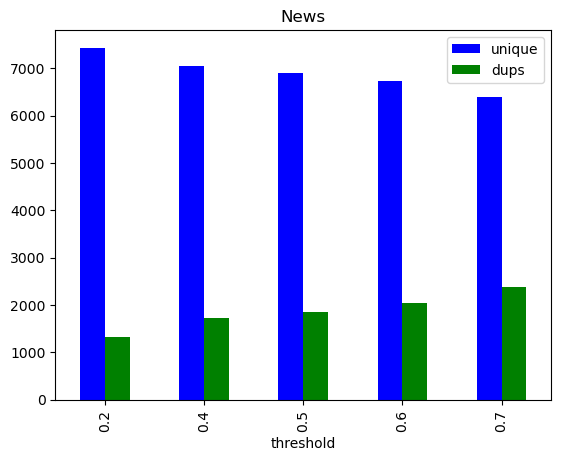

In [9]:
Organization_data.append(similarity("News", 0.75))

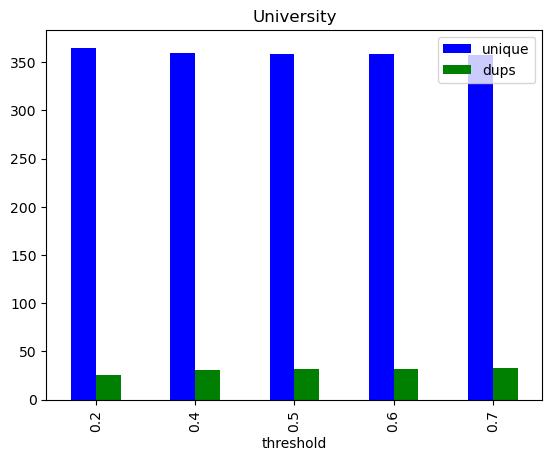

In [10]:
Organization_data.append(similarity("University", 1.0))

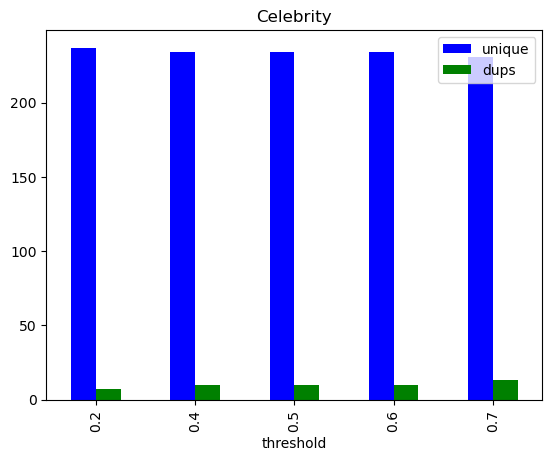

In [11]:
Organization_data.append(similarity("Celebrity", 1.0))

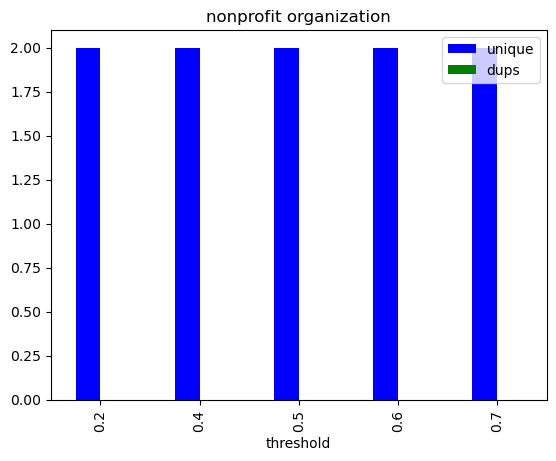

In [12]:
Organization_data.append(similarity("nonprofit organization", 1.0))

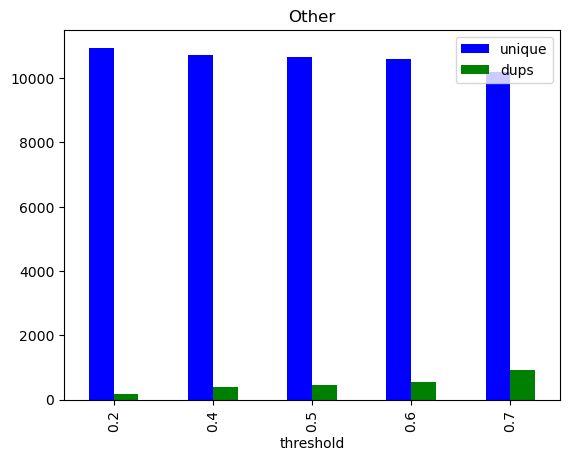

In [13]:
Organization_data.append(similarity("Other", 0.025))

**---> We can see the unique and duplicate count for each twitterer group from the above bar graphs.**

In [14]:
org_data= ['Other',
 'News',
 'Influencer',
 'School',
 'Government',
 'Celebrity',
 'University',
 'nonprofit organization']

**-->Here, I am collecting all the similarity data for each group and combining it to make a final data frame which will be plotted in a stacked format.**

In [15]:
count = 0
Organization_data_rows = []
for i in Organization_data:
    for j in i:
        j.append(org_data[count])
    count += 1

for i in Organization_data:
    for j in i:
        Organization_data_rows.append(j)

similarity_df = pd.DataFrame(Organization_data_rows, columns = ['records', 'duplicates', 'unique', 'jaccard_threshold', 'organization'])
similarity_df['average_duplicates_ratio'] = similarity_df['duplicates']/similarity_df['records']
similarity_df = similarity_df[['jaccard_threshold', 'average_duplicates_ratio', 'organization']]

final_df = []
for i in Organization_data:
    row = []
    org = i[0][-1]
    row.append(org)
    records = i[0][0]
    row.append(records)
    for j in i:
        row.append(j[1])
        row.append(j[2])
        row.append(j[3])
    final_df.append(row)

df_plot = pd.DataFrame(final_df, columns = ['Organizations', 'records', '% of duplicates at Jaccard Threshold of 0.2', 'unique_0.2', 'threshold_1',
                                                                       '% of duplicates at Jaccard Threshold of 0.4', 'unique_0.4', 'threshold_2',
                                                                       '% of duplicates at Jaccard Threshold of 0.5', 'unique_0.5', 'threshold_3',
                                                                       '% of duplicates at Jaccard Threshold of 0.6', 'unique_0.6', 'threshold_4',
                                                                       '% of duplicates at Jaccard Threshold of 0.7', 'unique_0.7', 'threshold_5'])


In [16]:
df_plot = df_plot.set_index(keys = 'Organizations', drop = True)
for i in df_plot.columns:
    if('Jaccard' in i):
        try:
            df_plot[i] = df_plot[i]/df_plot['records']
        except:
            pass
        
df_plot.drop(columns = ['records', 'threshold_1', 'threshold_2', 'threshold_3', 'threshold_4', 'threshold_5', 
                       'unique_0.2', 'unique_0.4', 'unique_0.5', 'unique_0.6', 'unique_0.7'], inplace = True)

df_plot = df_plot.round({'Jaccard Threshold of 0.2': 2, 
                         'Jaccard Threshold of 0.4': 2, 
                         'Jaccard Threshold of 0.5': 2, 
                         'Jaccard Threshold of 0.6': 2, 
                         'Jaccard Threshold of 0.7': 2})
df_plot

,% of duplicates at Jaccard Threshold of 0.2,% of duplicates at Jaccard Threshold of 0.4,% of duplicates at Jaccard Threshold of 0.5,% of duplicates at Jaccard Threshold of 0.6,% of duplicates at Jaccard Threshold of 0.7
Organizations,,,,,
Other,0.053700,0.071978,0.080045,0.090508,0.110929
News,0.038618,0.046748,0.053862,0.060976,0.075203
Influencer,0.059045,0.082915,0.092965,0.100503,0.113065
School,0.151705,0.196875,0.212273,0.232919,0.270446
Government,0.064103,0.079487,0.082051,0.082051,0.084615
Celebrity,0.028689,0.040984,0.040984,0.040984,0.053279
University,0.000000,0.000000,0.000000,0.000000,0.000000
nonprofit organization,0.016000,0.036135,0.041258,0.048360,0.083685


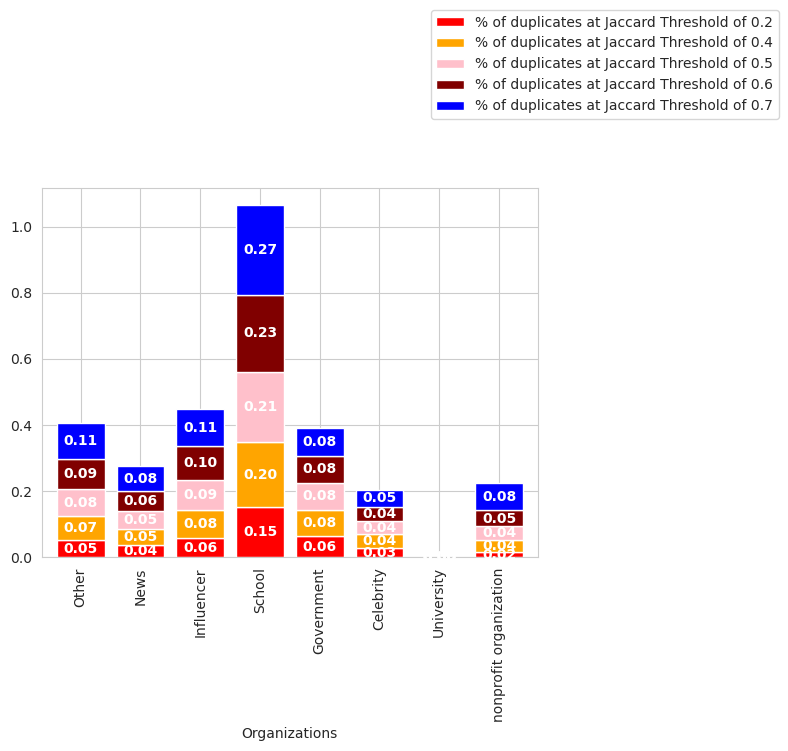

In [17]:
import seaborn as sns
sns.set_style("whitegrid")
plt.figure.figsize = (1000, 500)
fig = df_plot.plot.bar(width = 0.8,color=["red","orange","pink","maroon","blue"],stacked=True)
plt.legend(bbox_to_anchor=(1.5, 1.5))
for x in fig.containers:
    fig.bar_label(x, label_type='center', fmt = '%1.2f', weight='bold', color='white')
plt.show()

**--> The above stacked plot contains percentage of duplicates for each twitterer group for jaccard thresholds of 0.2,0.4,0.5,0.6 and 0.7.**

**--> Schools have the highest percentage of duplicates among all other groups. Celebrities have very less duplicates, their content is mostly original.**